In [23]:
from collections import defaultdict

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import py_pcha
from IPython.display import display
from minisom import MiniSom
from sklearn import decomposition
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

# Load data

In [8]:
df = pd.read_pickle("data/data_df.pkl")

In [9]:
measurements = ['BVP', 'EDA', 'HR', 'TEMP']

In [10]:
X = np.array([
    np.concatenate([df.loc[row, f'{m}_synched']
                    for m in measurements])
    for row in range(df.shape[0])
])
X.shape, X.size

((312, 76800), 23961600)

In [11]:
# Downscale!
# Uncomment later
X = X[:, np.arange(0, X.shape[1], 32)]
X.shape, X.size

((312, 2400), 748800)

In [12]:
# Normalize
X -= X.mean(0)
X /= X.std(0)

In [7]:
# # Onehotencode phase
# ohenc = OneHotEncoder(sparse_output=False)
# phase_onehot = ohenc.fit_transform(df.loc[:, 'phase'].to_numpy().reshape(-1, 1))
# X = np.hstack((X, phase_onehot))

# Apply method

In [13]:
n_components = 26
model = decomposition.PCA(n_components=n_components)
X_train_transformed = model.fit_transform(X)
X_hat = X_train_transformed.dot(model.components_) + model.mean_
L = 0.5 * np.linalg.norm(X - X_hat)**2
components = model.components_

In [14]:
XC, S, C, SSE, varexpl = py_pcha.PCHA(X, noc=n_components, delta=0.1)

X_hat = X @ C @ S
L = 0.5 * np.linalg.norm(X - X_hat)**2

# X_plot = np.asarray(np.concatenate((XC, XC[:,0]),axis=1))
X_plot = np.asarray(XC)

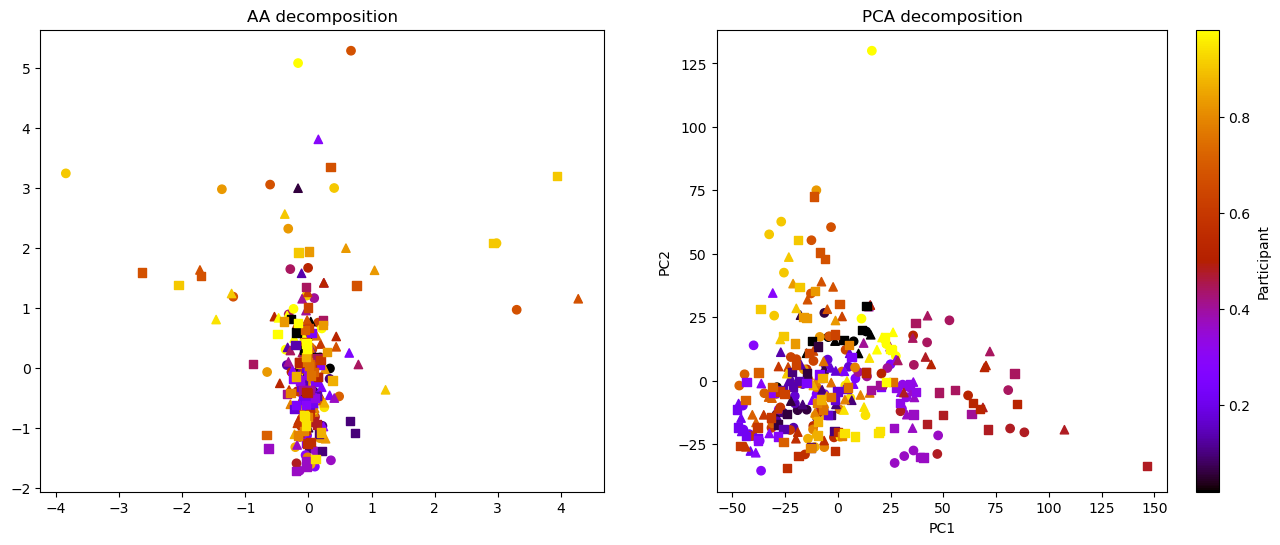

In [35]:
cm = 'gnuplot'

colours = (np.arange(0, 26) + .5) / 26
participant_to_colour = {
    participant: colour
    for participant, colour in zip(df.loc[:, 'participant'].unique(), colours)
}
c = np.array(
    list(map(lambda x: participant_to_colour[x], df.loc[:, 'participant'])))
markers = "o^s"
phase_to_marker = {
    phase: marker for phase, marker in zip(df.loc[:, 'phase'].unique(), markers)
}

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
for phase in df.loc[:, 'phase'].unique():
    mask = df.loc[:, 'phase'] == phase
    marker = phase_to_marker[phase]
    ax.set_title('AA decomposition')
    sc = ax.scatter(X_plot[mask, 0],
                    X_plot[mask, 1],
                    c=c[mask],
                    marker=marker,
                    cmap=cm)  #,'k-', linewidth=2)
    # cbar = plt.colorbar(sc)
    # cbar.set_label('Person ID')

    ax1.set_title('PCA decomposition')
    sc = ax1.scatter(X_train_transformed[mask, 0],
                     X_train_transformed[mask, 1],
                     c=c[mask],
                     marker=marker,
                     cmap=cm)
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
cbar = plt.colorbar(sc)
cbar.set_label('Participant')

c:\Users\Andre\miniconda3\lib\site-packages\minisom.py:384: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[:, pc_order[0]] + \


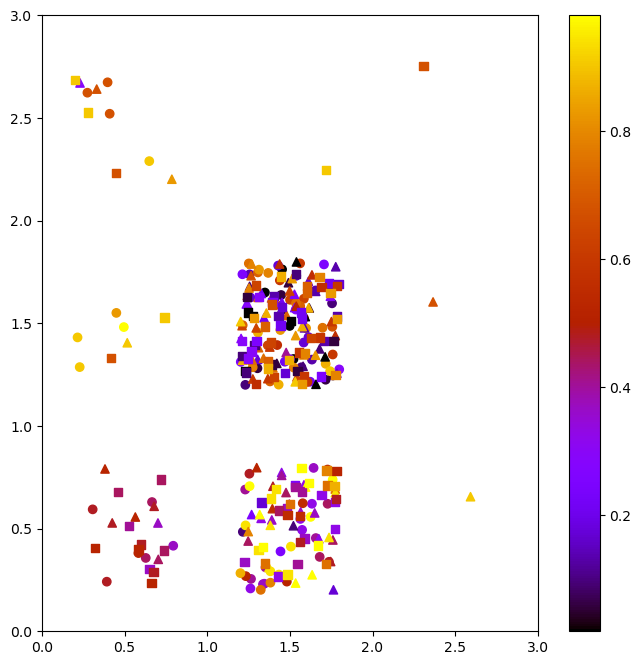

In [40]:
som_shape = (3, 3)
som = MiniSom(som_shape[0],
              som_shape[1],
              n_components,
              sigma=0.1,
              learning_rate=0.5)

som.pca_weights_init(X)
som.train_batch(X, 5000, verbose=False)

plt.figure(figsize=(8, 8))
y = df.loc[:, 'participant']
_, y = np.unique(y, return_inverse=True)
for phase in df.loc[:, 'phase'].unique():
    mask = df.loc[:, 'phase'] == phase
    marker = phase_to_marker[phase]
    xvals, yvals = [], []
    for x, t in zip(X_plot[mask, :], y[mask]):  # scatterplot
        w = som.winner(x)
        xval = w[0] + .5 + 0.6 * np.random.rand(1) - 0.3
        yval = w[1] + .5 + 0.6 * np.random.rand(1) - 0.3
        xvals.append(xval)
        yvals.append(yval)
    plt.scatter(xvals, yvals, c=c[mask], marker=marker, cmap=cm)

plt.axis([0, som.get_weights().shape[0], 0, som.get_weights().shape[1]])
plt.colorbar()
plt.savefig('figs/clusters.png', dpi=200)
plt.show()

- find cluster center, find alle de personer / trials der tilhører den cluster
- for den cluster tag deres mean response og visualiser som et radar plot

In [28]:
centroids = som.get_weights()

# y = np.arange(n_components)
assigned_centroid = defaultdict(list)
for i, (x, t) in enumerate(zip(X, y)):
    w = som.winner(x)
    xval = w[0]
    yval = w[1]
    assigned_centroid[(xval, yval)].append(i)

# assigned_centroid

they are numbered as x, y from the lower left

In [29]:
responses = pd.DataFrame()
for cluster, idx in assigned_centroid.items():
    responses_cluster = pd.concat([df.loc[i, 'response'].T[5:].T for i in idx],
                                  axis=0).mean()
    responses = pd.concat([responses, responses_cluster], axis=1)
responses = responses.T
responses

,hostile,alert,ashamed,inspired,nervous,determined,attentive,afraid,active,frustrated,difficulty
0,1.021127,2.422535,1.246479,2.401408,1.450704,3.098592,3.035211,1.049296,2.788732,2.232394,2.918605
0,1.087591,2.036496,1.204380,2.044444,1.313869,2.837037,2.625000,1.066176,2.389706,1.795620,3.636364
0,1.086957,1.695652,1.260870,1.739130,1.521739,2.347826,2.217391,1.000000,2.000000,1.782609,5.500000
0,1.000000,2.285714,1.000000,2.000000,1.000000,2.857143,2.857143,1.000000,2.571429,1.857143,0.857143
0,1.000000,2.000000,1.000000,2.500000,1.000000,2.500000,3.000000,1.000000,3.000000,3.500000,0.000000
0,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,7.000000,5.000000


## One radar plot for each phase

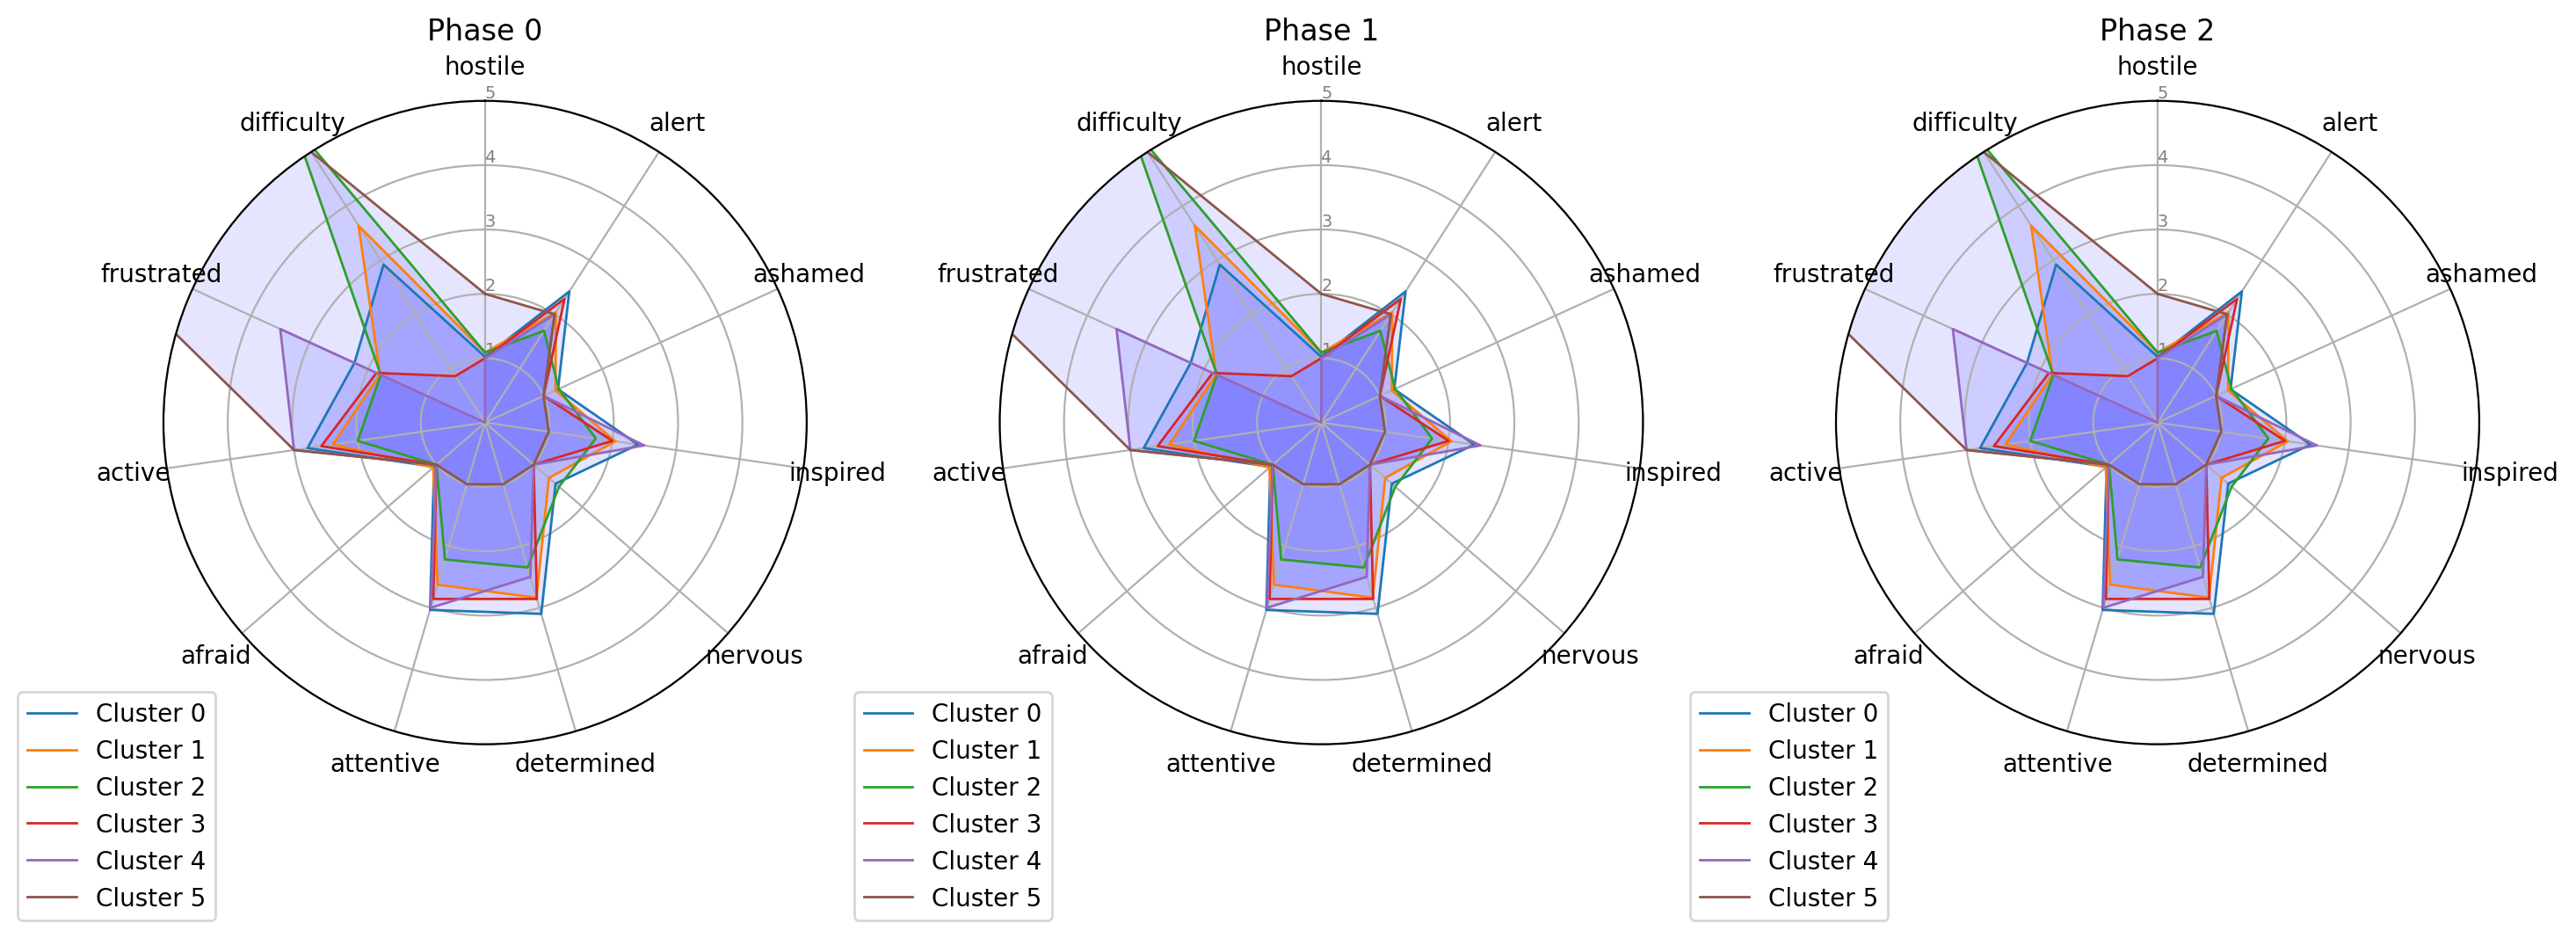

In [47]:
N = responses.shape[1]
# We need to repeat cthe first value to close the circular graph:

# https://www.python-graph-gallery.com/391-radar-chart-with-several-individuals
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Initialise the spider plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'},dpi=200, figsize=(17,5))
fig.subplots_adjust(wspace=0.3)
# If you want the first axis to be on top:
for i, ax in enumerate(axs):
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels
    ax.set_xticks(angles[:-1], responses.columns)

    # Draw ylabels
    ax.set_title(f'Phase {i}')
    ax.set_rlabel_position(0)
    ax.set_yticks(list(range(1, 6)), ["1", "2", "3", "4", '5'], color="grey", size=7)
    ax.set_ylim(0, 5)
    for i in range(len(responses)):
        response = responses.iloc[i, :]
        values = response.to_numpy()
        values = np.append(values, values[:1])
        ax.plot(angles,
                values,
                linewidth=1,
                linestyle='solid',
                label=f"Cluster {i}")
        ax.fill(angles, values, 'b', alpha=0.1)
        # Add legend
    ax.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.savefig('figs/emotions.png', dpi=200)
plt.show()

### Stats

In [15]:
## Mean and variance of biosignals across the phases
# to make life easier for myself, I am excluding cohort 3
cohorts = ['D1_1', 'D1_2']
ids = {
    'D1_1': ['ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5', 'ID_6', 'ID_7', 'ID_8'],
    'D1_2': ['ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5', 'ID_6']
}
rounds = ['round_1', 'round_2', 'round_3', 'round_4']
phases = [1, 2, 3]

HR_mean = np.zeros([3, 14])
BVP_mean = np.zeros([3, 14])
EDA_mean = np.zeros([3, 14])
TEMP_mean = np.zeros([3, 14])
HR_std = np.zeros([3, 14])
BVP_std = np.zeros([3, 14])
EDA_std = np.zeros([3, 14])
TEMP_std = np.zeros([3, 14])
for p in phases:
    id_index = 0
    for cohort in cohorts:
        for ID in ids[cohort]:
            for rond in rounds:
                HR = pd.read_csv(
                    f'dataset/{cohort}/{ID}/{rond}/phase{p}/HR.csv',
                    index_col=0,
                    parse_dates=["time"])
                BVP = pd.read_csv(
                    f'dataset/{cohort}/{ID}/{rond}/phase{p}/BVP.csv',
                    index_col=0,
                    parse_dates=["time"])
                EDA = pd.read_csv(
                    f'dataset/{cohort}/{ID}/{rond}/phase{p}/EDA.csv',
                    index_col=0,
                    parse_dates=["time"])
                TEMP = pd.read_csv(
                    f'dataset/{cohort}/{ID}/{rond}/phase{p}/TEMP.csv',
                    index_col=0,
                    parse_dates=["time"])
                HR_mean[p - 1, id_index] += 1 / 4 * np.mean(
                    HR["HR"])  # 1/4 to get average of rounds
                BVP_mean[p - 1, id_index] += 1 / 4 * np.mean(BVP["BVP"])
                EDA_mean[p - 1, id_index] += 1 / 4 * np.mean(EDA["EDA"])
                TEMP_mean[p - 1, id_index] += 1 / 4 * np.mean(TEMP["TEMP"])
                HR_std[p - 1, id_index] += 1 / 4 * np.std(HR["HR"])
                BVP_std[p - 1, id_index] += 1 / 4 * np.std(BVP["BVP"])
                EDA_std[p - 1, id_index] += 1 / 4 * np.std(EDA["EDA"])
                TEMP_std[p - 1, id_index] += 1 / 4 * np.std(TEMP["TEMP"])
            id_index += 1

print("Average HR of the phases are:", np.mean(HR_mean, axis=1))
print("With average standard deviation:", np.mean(HR_std, axis=1))
print("Average BVP of the phases are:", np.mean(BVP_mean, axis=1))
print("With average standard deviation:", np.mean(BVP_std, axis=1))
print("Average EDA of the phases are:", np.mean(EDA_mean, axis=1))
print("With average standard deviation:", np.mean(EDA_std, axis=1))
print("Average TEMP of the phases are:", np.mean(TEMP_mean, axis=1))
print("With average standard deviation:", np.mean(TEMP_std, axis=1))

FileNotFoundError: [Errno 2] No such file or directory: 'dataset/D1_1/ID_1/round_1/phase1/HR.csv'

In [ ]:
X_mean = np.concatenate((HR_mean.T, BVP_mean.T, EDA_mean.T, TEMP_mean.T),
                        axis=1)
pd.DataFrame(X_mean,
             columns=[
                 'HR_p1', 'HR_p2', 'HR_p3', 'BVP_p1', 'BVP_p2', 'BVP_p3',
                 'EDA_p1', 'EDA_p2', 'EDA_p3', 'TEMP_p1', 'TEMP_p2', 'TEMP_p3'
             ])

### Clustering 

In [ ]:
kmeans = KMeans(n_clusters=2, n_init=1, random_state=1)
y_pred_HR = kmeans.fit_predict(HR_mean.T)
y_pred_BVP = kmeans.fit_predict(BVP_mean.T)
y_pred_EDA = kmeans.fit_predict(EDA_mean.T)
y_pred_TEMP = kmeans.fit_predict(TEMP_mean.T)

print("HR clusters:  ", y_pred_HR)
print("BVP clusters: ", y_pred_BVP)
print("EDA clusters: ", y_pred_EDA)
print("TEMP clusters:", y_pred_TEMP)

In [ ]:
print("HR std clusters:  ", kmeans.fit_predict(HR_std.T))
print("BVP std clusters: ", kmeans.fit_predict(BVP_std.T))
print("EDA std clusters: ", kmeans.fit_predict(EDA_std.T))
print("TEMP std clusters:", kmeans.fit_predict(TEMP_std.T))

In [ ]:
kmeans = KMeans(n_clusters=2, n_init=1, random_state=1)
y_pred = kmeans.fit_predict(X_mean)
y_pred

In [ ]:
fig, ax = plt.subplots(12, 12, figsize=(10, 5), tight_layout=True)
for i in range(12):
    for j in range(12):
        ax[i, j].scatter(X_mean[:, i], X_mean[:, j], marker='.', c=y_pred)
plt.show()

In [ ]:
X_mean_mean = np.array((np.mean(HR_mean, axis=0), np.mean(BVP_mean, axis=0),
                        np.mean(EDA_mean, axis=0), np.mean(TEMP_mean,
                                                           axis=0))).T
y_pred2 = kmeans.fit_predict(X_mean_mean)
y_pred2

In [ ]:
fig, ax = plt.subplots(4,
                       4,
                       figsize=(10, 5),
                       tight_layout=True,
                       sharex='col',
                       sharey='row')
for i in range(4):
    for j in range(4):
        ax[i, j].scatter(X_mean_mean[:, j],
                         X_mean_mean[:, i],
                         marker='.',
                         c=y_pred2)
plt.show()

In [ ]:
res["upset"][0]

In [ ]:
not (np.isnan(res["upset"]))

In [ ]:
not False

In [ ]:
## Combined score of responses across the phases and ID's
# to make life easier for myself, I am excluding cohort 3
cohorts = ['D1_1', 'D1_2']
ids = {
    'D1_1': ['ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5', 'ID_6', 'ID_7', 'ID_8'],
    'D1_2': ['ID_1', 'ID_2', 'ID_3', 'ID_4', 'ID_5', 'ID_6']
}
rounds = ['round_1', 'round_2', 'round_3', 'round_4']
phases = [1, 2, 3]

responses_mean = np.zeros([14, 12])
id_index = 0
for cohort in cohorts:
    for ID in ids[cohort]:
        for rond in rounds:
            for p in phases:
                res = pd.read_csv(
                    f'dataset/{cohort}/{ID}/{rond}/phase{p}/response.csv',
                    index_col=0)
                responses_mean[id_index, 0] += (
                    1 / (4 + 3) *
                    res["upset"] if not np.isnan(res["upset"][0]) else 0
                )  #1/(4+3) * res["upset"] # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 1] += (
                    1 / (4 + 3) *
                    res["hostile"] if not np.isnan(res["hostile"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 2] += (
                    1 / (4 + 3) *
                    res["alert"] if not np.isnan(res["alert"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 3] += (
                    1 / (4 + 3) *
                    res["ashamed"] if not np.isnan(res["ashamed"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 4] += (
                    1 / (4 + 3) *
                    res["inspired"] if not np.isnan(res["inspired"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 5] += (
                    1 / (4 + 3) *
                    res["nervous"] if not np.isnan(res["nervous"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 6] += (
                    1 / (4 + 3) * res["determined"]
                    if not np.isnan(res["determined"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 7] += (
                    1 / (4 + 3) *
                    res["attentive"] if not np.isnan(res["attentive"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 8] += (
                    1 / (4 + 3) *
                    res["afraid"] if not np.isnan(res["afraid"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 9] += (
                    1 / (4 + 3) *
                    res["active"] if not np.isnan(res["active"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                responses_mean[id_index, 10] += (
                    1 / (4 + 3) * (res["frustrated"] / 2)
                    if not np.isnan(res["frustrated"][0]) else 0
                )  # 1/(4+3) average of 4 rounds and 3 phases
                if p == 2:
                    responses_mean[id_index, 11] += (
                        1 / (4) * (res["difficulty"] / 2)
                        if not np.isnan(res["difficulty"][0]) else 0
                    )  # 1/(4) average of 4 rounds
        id_index += 1

In [ ]:
pd.DataFrame(responses_mean,
             columns=[
                 "upset", "hostile", "alert", "ashamed", "inspired", "nervous",
                 "determined", "attentive", "afraid", "active", "frustrated",
                 "difficulty"
             ])

In [ ]:
np.nanmean(responses_mean, axis=1)

In [ ]:
colors = []
for i in range(len(y_pred2)):
    if y_pred2[i] == 0:
        colors.append("purple")
    elif y_pred2[i] == 1:
        colors.append("yellow")
fig = plt.figure(figsize=(10, 5))
plt.bar(x=[
    'C1_ID_1', 'C1_ID_2', 'C1_ID_3', 'C1_ID_4', 'C1_ID_5', 'C1_ID_6', 'C1_ID_7',
    'C1_ID_8', 'C2_ID_1', 'C2_ID_2', 'C2_ID_3', 'C2_ID_4', 'C2_ID_5', 'C2_ID_6'
],
        height=np.nanmean(responses_mean, axis=1),
        color=colors)

In [ ]:
fig = plt.figure(figsize=(10, 5))
purple_line = plt.plot([], [], color='purple', linewidth=2,
                       label='Cluster 0')[0]
yellow_line = plt.plot([], [], color='yellow', linewidth=2,
                       label='Cluster 1')[0]
responselabels = [
    "upset", "hostile", "alert", "ashamed", "inspired", "nervous", "determined",
    "attentive", "afraid", "active", "frustrated", "difficulty"
]
for col in range(responses_mean.T.shape[1]):
    if y_pred2[col] == 0:
        cluster_color = ("purple")
    elif y_pred2[col] == 1:
        cluster_color = ("yellow")
    plt.plot(responselabels, responses_mean.T[:, col], color=cluster_color)
plt.legend(handles=[purple_line, yellow_line], loc='best')

In [ ]:
y_pred_responses = kmeans.fit_predict(responses_mean)

In [ ]:
plt.scatter(np.nanmean(responses_mean, axis=1),
            np.nanmean(responses_mean, axis=1),
            marker='.',
            c=y_pred_responses)